# Experimento 1 - Sin Restricciones Adicionales

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys

sys.path.append("..")

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# Use latex
plt.rc("text", usetex=True)

## Definición

In [6]:
from experimento import Experimento
from src.generacion import (
    GeneradorInstancias,
    DistribucionIndependiente,
    DistribucionUniforme,
    DistribucionNormal,
)


experimento = Experimento(
    nombre="exp1",
    generador=GeneradorInstancias(
        cantidad_trabajadores=DistribucionUniforme(5, 10),
        cantidad_ordenes=DistribucionUniforme(5, 20),
        parametros_ordenes=DistribucionIndependiente(
            DistribucionNormal(10000, 2000),
            DistribucionUniforme(3, 10),
        ),
    ),
    N=1000,
    seed=42,
)

## Ejecución

In [7]:
resultados = experimento.ejecutar()

## Análisis

In [30]:
from graficos import histograma, histograma_discreto, histograma_hue

### Distribución Función Objetivo

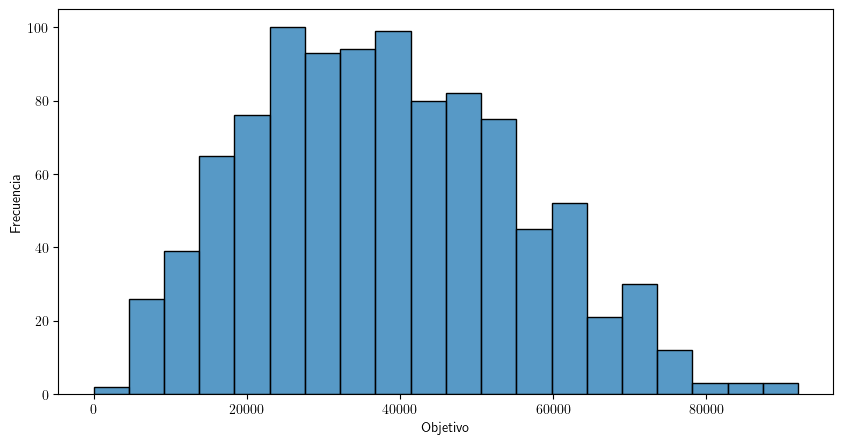

In [10]:
fig = histograma(resultados.objetivos, xlabel="Objetivo")

experimento.guardar_imagen(fig, "distribucion_objetivo")

In [14]:
objs = pd.Series(resultados.objetivos)

In [15]:
objs.describe()

count     1000.000000
mean     38078.711085
std      17125.097866
min          0.000000
25%      24923.660702
50%      37030.539963
75%      50301.188755
max      92044.492136
dtype: float64

In [16]:
(objs <= 1e-8).mean()

np.float64(0.001)

#### Proporción de las Cotas

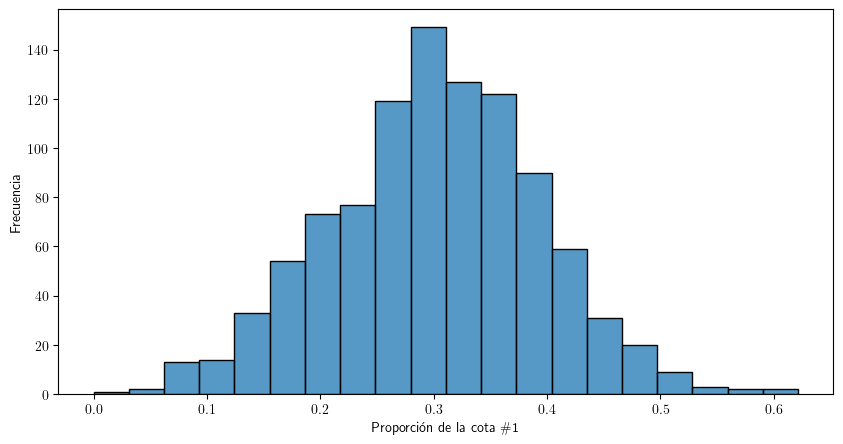

In [37]:
proporciones_optimo = [
    obj / instancia.beneficio_maximo()
    for obj, instancia in zip(resultados.objetivos, resultados.instancias)
]

fig = histograma(proporciones_optimo, xlabel="Proporción de la cota \#1")

experimento.guardar_imagen(fig, "distribucion_proporcion_objetivo")

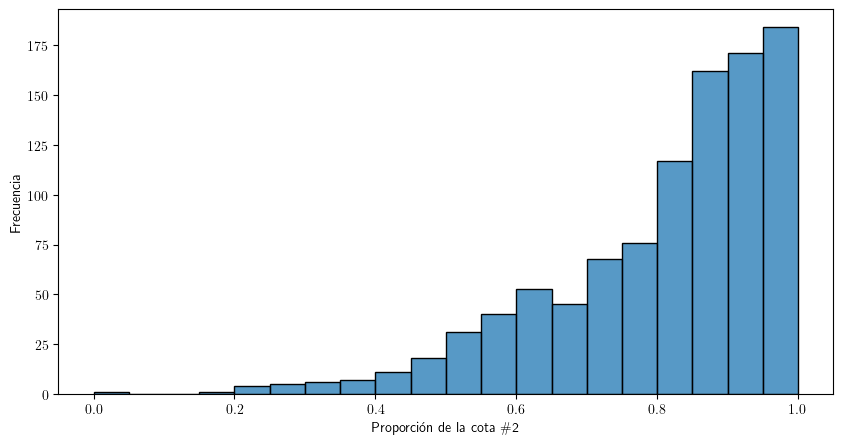

In [38]:
proporciones_optimo_ajustado = [
    obj / instancia.bmp()
    for obj, instancia in zip(resultados.objetivos, resultados.instancias)
]

fig = histograma(proporciones_optimo_ajustado, xlabel="Proporción de la cota \#2")

experimento.guardar_imagen(fig, "distribucion_proporcion_objetivo_ajustado")

In [21]:
poa = pd.Series(proporciones_optimo_ajustado)

In [22]:
(poa >= 0.9).sum()

np.int64(355)

In [24]:
((1 - poa) < 1e-8).sum()

np.int64(103)

### Distribución de Cantidad de Órdenes

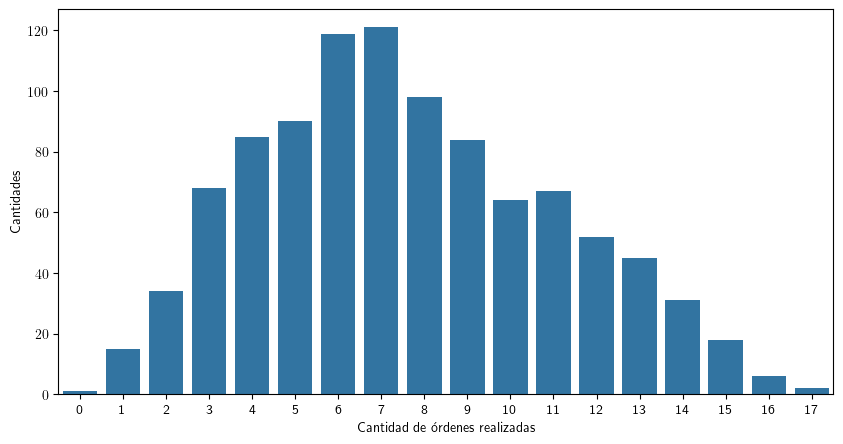

In [26]:
fig = histograma_discreto(
    [solucion.cantidad_de_ordenes_realizadas() for solucion in resultados.soluciones],
    xlabel="Cantidad de órdenes realizadas",
)

experimento.guardar_imagen(fig, "distribucion_cantidad_ordenes")

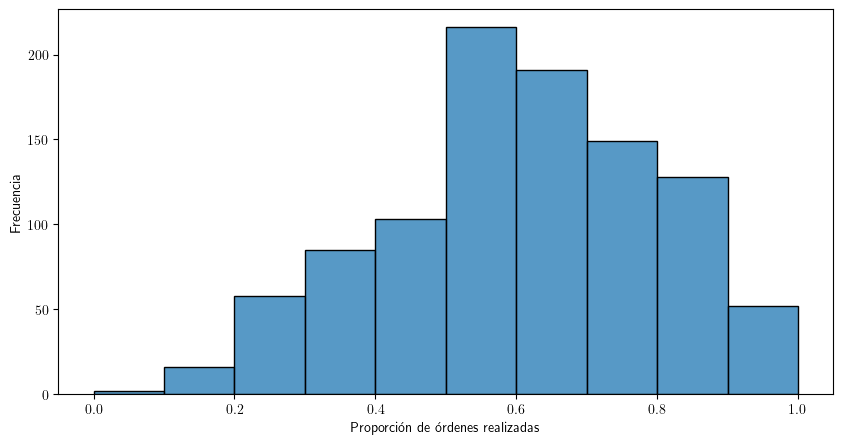

In [28]:
proporcion_ordenes = [
    solucion.cantidad_de_ordenes_realizadas() / len(instancia.ordenes)
    for instancia, solucion in zip(resultados.instancias, resultados.soluciones)
]

fig = histograma(proporcion_ordenes, xlabel="Proporción de órdenes realizadas", bins=10)

experimento.guardar_imagen(fig, "distribucion_proporcion_ordenes")

### Beneficio Máximo (Cota más Ajustada)

In [29]:
ordenes = [
    (orden, instancia, solucion)
    for instancia, solucion in zip(resultados.instancias, resultados.soluciones)
    for orden in instancia.ordenes
]

df_ordenes = pd.DataFrame(
    {
        "beneficio": [orden.beneficio for orden, _, _ in ordenes],
        "cant_trab": [orden.cant_trab for orden, _, _ in ordenes],
        "beneficio_maximo": [
            orden.beneficio - 1000 * orden.cant_trab for orden, _, _ in ordenes
        ],
        "realizada": [
            orden.id in solucion.ordenes_realizadas for orden, _, solucion in ordenes
        ],
        "realizable": [
            orden.cant_trab <= instancia.cantidad_trabajadores
            for orden, instancia, _ in ordenes
        ],
    }
)

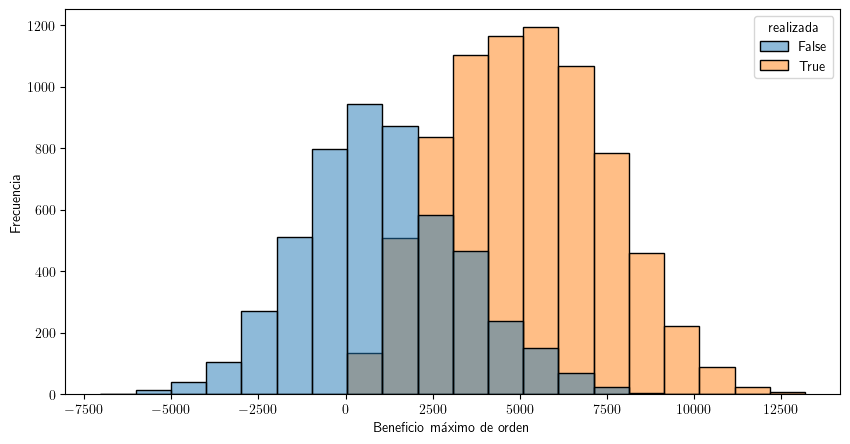

In [31]:
fig = histograma_hue(
    df_ordenes,
    x="beneficio_maximo",
    hue="realizada",
    xlabel="Beneficio máximo de orden",
)

experimento.guardar_imagen(fig, "distribucion_beneficio_maximo_realizada")

In [32]:
(df_ordenes[~df_ordenes["realizada"]]["beneficio_maximo"] >= 0).mean()

np.float64(0.6643754909662215)

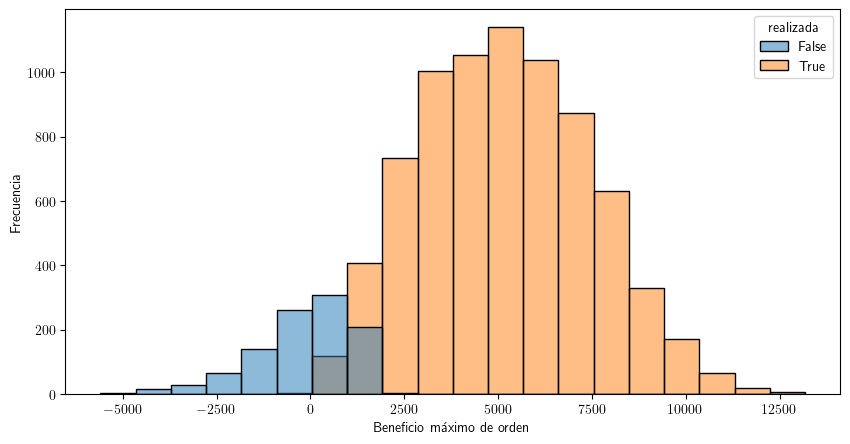

In [33]:
fig = histograma_hue(
    df_ordenes[df_ordenes["realizable"]],
    x="beneficio_maximo",
    hue="realizada",
    xlabel="Beneficio máximo de orden",
)

experimento.guardar_imagen(fig, "distribucion_beneficio_maximo_realizable")

In [34]:
(
    df_ordenes[df_ordenes["realizable"] & ~df_ordenes["realizada"]]["beneficio_maximo"]
    >= 0
).mean()

np.float64(0.5121006776379478)

#### Proporción del Óptimo con la Cota más Ajustada

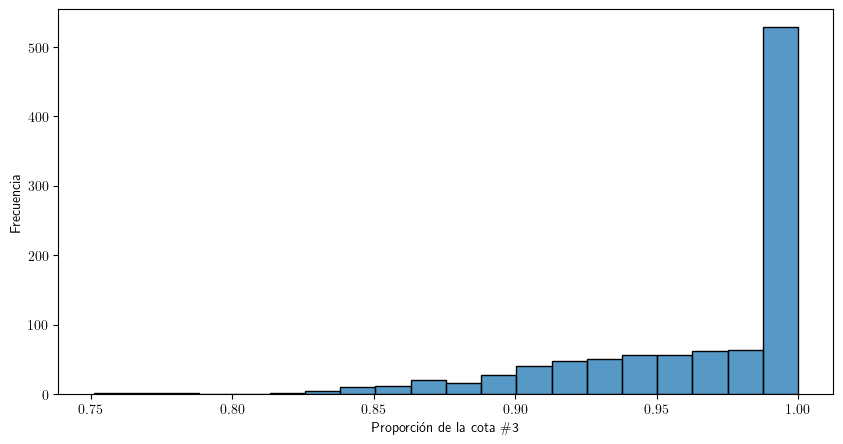

In [39]:
fig = histograma(
    [
        obj / instancia.bmp_realizables()
        for obj, instancia in zip(resultados.objetivos, resultados.instancias)
        if instancia.bmp_realizables() > 0
    ],
    xlabel="Proporción de la cota \#3",
)

experimento.guardar_imagen(fig, "distribucion_proporcion_objetivo_realizable")